RMSE Scenario A (total cases): 9.74
RMSE Scenario B (active cases): 157.96
RMSE Scenario C (recovered):     11.22
RMSE Scenario D (removed):       6.90


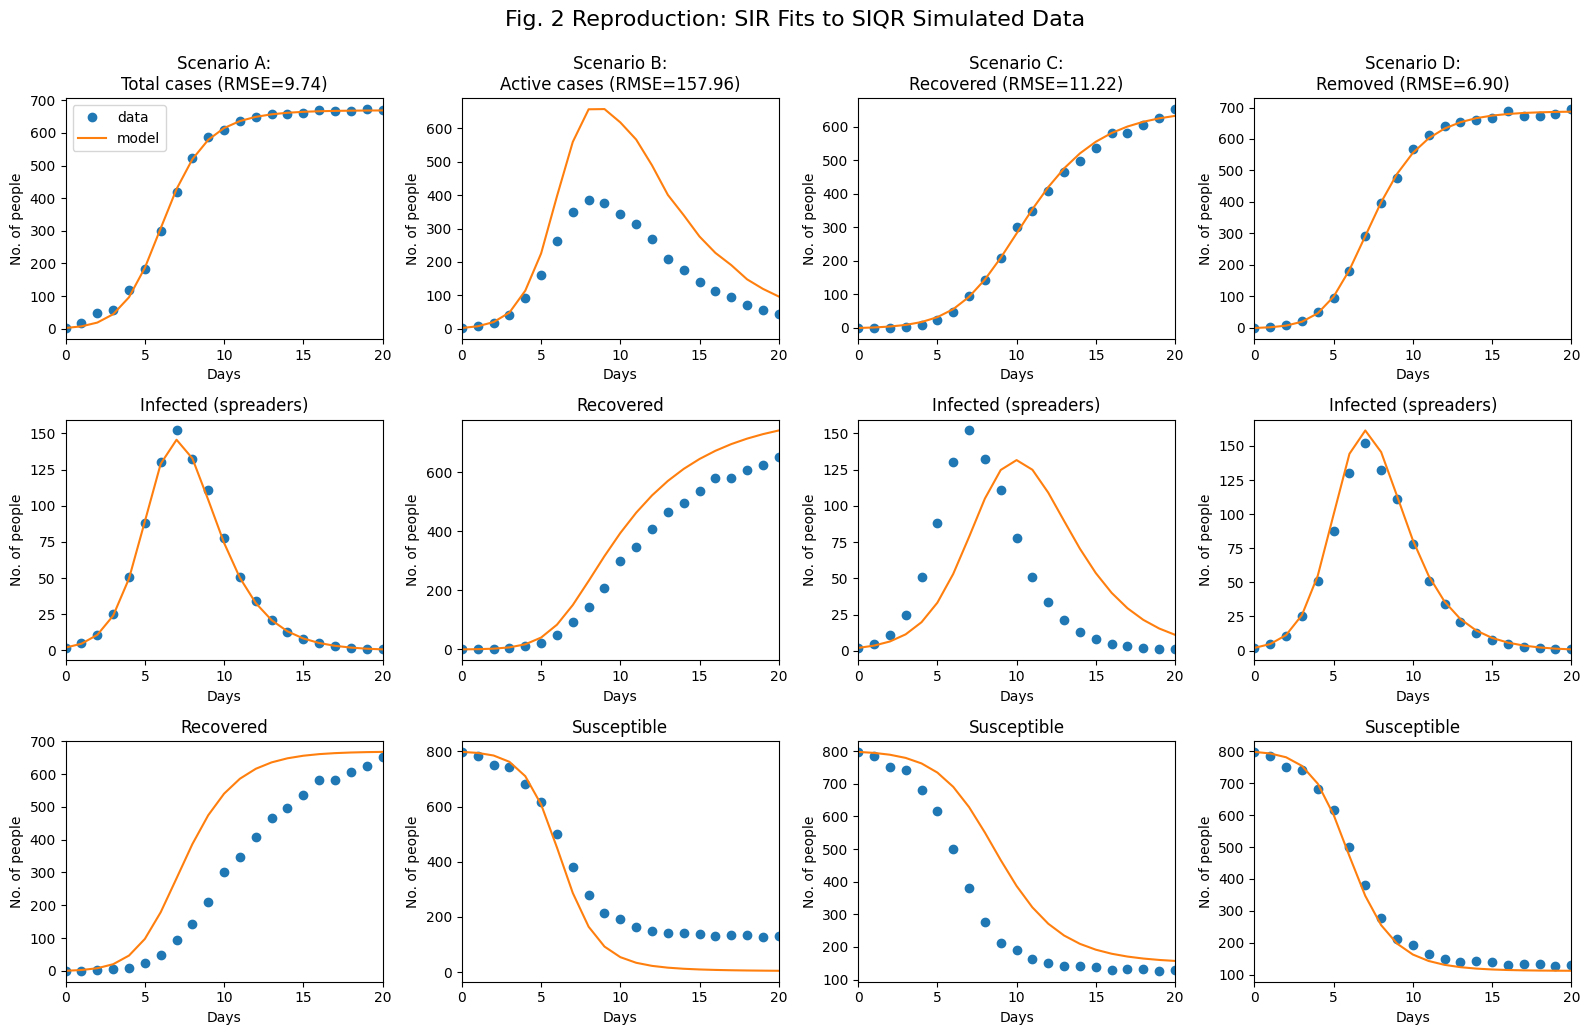

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# ==== 1. Data A.1 SIQR Simulated Data ====
t = np.arange(0, 21)
S = np.array([798, 784, 751, 742, 682, 616, 500, 380, 278, 213, 192, 164,
              150, 141, 143, 139, 130, 133, 133, 127, 130])
I = np.array([2, 5, 11, 25, 51, 88, 130, 152, 132, 111, 78, 51,
              34, 21, 13, 8, 5, 3, 2, 1, 1])
Q = np.array([0, 2, 7, 17, 41, 73, 132, 197, 254, 267, 267, 264,
              234, 188, 164, 131, 108, 93, 68, 54, 43])
R = np.array([0, 0, 1, 4, 10, 23, 49, 94, 142, 209, 300, 348,
              407, 465, 497, 535, 581, 581, 606, 625, 652])
N = 800
I0, Q0, R0 = I[0], Q[0], R[0]
S0 = N - I0 - Q0 - R0

# ==== 2. Helper for RMSE ====
def rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted)**2))

# ==== 3. SIR ODE ====
def sir_ode(y, t, a, b):
    S, I = y
    dSdt = -a * S * I
    dIdt = a * S * I - b * I
    return [dSdt, dIdt]

def solve_sir(a, b):
    y0 = [S0, I0]
    sol = odeint(sir_ode, y0, t, args=(a, b))
    S_mod, I_mod = sol.T
    R_mod = N - S_mod - I_mod
    return S_mod, I_mod, R_mod

# ==== 4. Four Scenario parameters ====
# Scenario A: fit N - S
a_A, b_A = 0.002, 0.74
# Scenario B: fit I + Q
a_B, b_B = 0.00143, 0.21
# Scenario C: fit R
a_C, b_C = 0.00144, 0.56
# Scenario D: fit Q + R
a_D, b_D = 0.00197, 0.69

# ==== 5. Solve SIR for each scenario ====
S_A, I_A, R_A = solve_sir(a_A, b_A)
S_B, I_B, R_B = solve_sir(a_B, b_B)
S_C, I_C, R_C = solve_sir(a_C, b_C)
S_D, I_D, R_D = solve_sir(a_D, b_D)

# ==== 6. Compute RMSEs ====
rmse_A = rmse(N - S, N - S_A)
rmse_B = rmse(I + Q, I_B + Q)     # note: Q from data
rmse_C = rmse(R, R_C)
rmse_D = rmse(Q + R, R_D)         # approximating Q+R with R_D

print(f"RMSE Scenario A (total cases): {rmse_A:.2f}")
print(f"RMSE Scenario B (active cases): {rmse_B:.2f}")
print(f"RMSE Scenario C (recovered):     {rmse_C:.2f}")
print(f"RMSE Scenario D (removed):       {rmse_D:.2f}")

# ==== 7. Plot in 3x4 grid ====
fig, axes = plt.subplots(3, 4, figsize=(16, 10))

# Row 1: fitted data vs model
axes[0, 0].plot(t, N - S, 'o', label='data')
axes[0, 0].plot(t, N - S_A, '-', label='model')
axes[0, 0].set_title(f"Scenario A:\nTotal cases (RMSE={rmse_A:.2f})")
axes[0, 0].legend()

axes[0, 1].plot(t, I + Q, 'o')
axes[0, 1].plot(t, I_B + Q, '-')
axes[0, 1].set_title(f"Scenario B:\nActive cases (RMSE={rmse_B:.2f})")

axes[0, 2].plot(t, R, 'o')
axes[0, 2].plot(t, R_C, '-')
axes[0, 2].set_title(f"Scenario C:\nRecovered (RMSE={rmse_C:.2f})")

axes[0, 3].plot(t, Q + R, 'o')
axes[0, 3].plot(t, R_D, '-')
axes[0, 3].set_title(f"Scenario D:\nRemoved (RMSE={rmse_D:.2f})")

# Row 2: Infected
axes[1, 0].plot(t, I, 'o');       axes[1, 0].plot(t, I_A, '-'); axes[1, 0].set_title("Infected (spreaders)")
axes[1, 1].plot(t, R, 'o');       axes[1, 1].plot(t, R_B, '-'); axes[1, 1].set_title("Recovered")
axes[1, 2].plot(t, I, 'o');       axes[1, 2].plot(t, I_C, '-'); axes[1, 2].set_title("Infected (spreaders)")
axes[1, 3].plot(t, I, 'o');       axes[1, 3].plot(t, I_D, '-'); axes[1, 3].set_title("Infected (spreaders)")

# Row 3: Recovered / Susceptible
axes[2, 0].plot(t, R, 'o');       axes[2, 0].plot(t, R_A, '-'); axes[2, 0].set_title("Recovered")
axes[2, 1].plot(t, S, 'o');       axes[2, 1].plot(t, S_B, '-'); axes[2, 1].set_title("Susceptible")
axes[2, 2].plot(t, S, 'o');       axes[2, 2].plot(t, S_C, '-'); axes[2, 2].set_title("Susceptible")
axes[2, 3].plot(t, S, 'o');       axes[2, 3].plot(t, S_D, '-'); axes[2, 3].set_title("Susceptible")

for ax in axes.flat:
    ax.set_xlim(0, 20)
    ax.set_ylabel("No. of people")
    ax.set_xlabel("Days")

plt.tight_layout()
plt.suptitle("Fig. 2 Reproduction: SIR Fits to SIQR Simulated Data", fontsize=16, y=1.03)
plt.show()



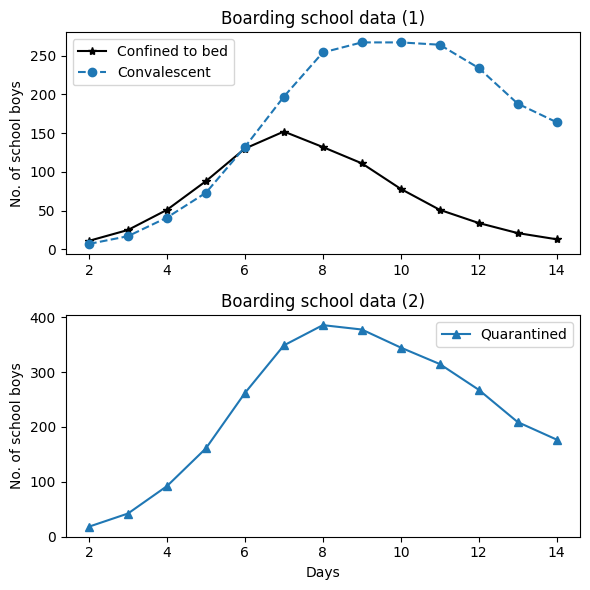

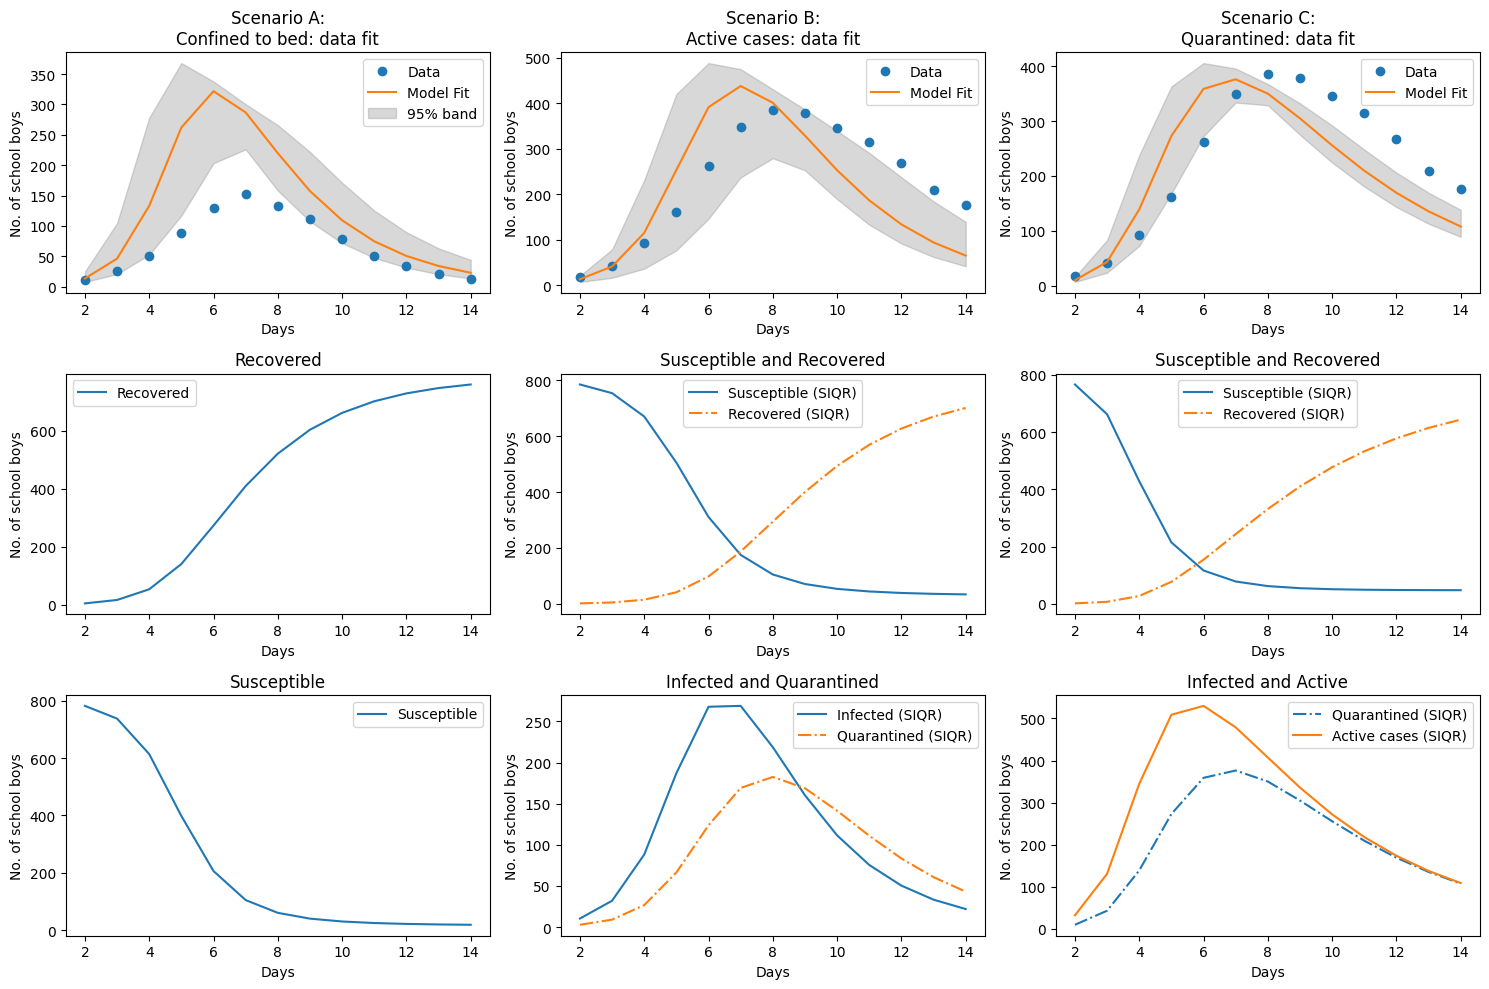

In [2]:
# Final full code to reproduce Fig. 3 with real data and 95% prediction bands
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# ==== Real Data A.1 (t = 0~20) ====
days_full = np.arange(0, 21)
S_data = np.array([798, 784, 751, 742, 682, 616, 500, 380, 278, 213, 192, 164, 150, 141, 143, 139, 130, 133, 133, 127, 130])
I_data = np.array([2, 5, 11, 25, 51, 88, 130, 152, 132, 111, 78, 51, 34, 21, 13, 8, 5, 3, 2, 1, 1])
Q_data = np.array([0, 2, 7, 17, 41, 73, 132, 197, 254, 267, 267, 264, 234, 188, 164, 131, 108, 93, 68, 54, 43])
R_data = np.array([0, 0, 1, 4, 10, 23, 49, 94, 142, 209, 300, 348, 407, 465, 497, 535, 581, 581, 606, 625, 652])

i_idx = np.arange(2, 15)
t_days = np.arange(2, 15)
confined = I_data[i_idx]
convalescent = Q_data[i_idx]
quarantined = confined + convalescent
active = confined + convalescent

N = 800
I0, Q0, R0 = 1, 0, 0
S0 = N - I0 - Q0 - R0

a_A, b_A = 0.00219, 0.44
a_B, b_B, g_B = 0.00209, 0.49, 0.60
a_C, b_C, g_C = 0.00297, 0.79, 0.24

# === Models ===
def sir_ode(y, t, a, b):
    S, I = y
    dS = -a * S * I
    dI = a * S * I - b * I
    return [dS, dI]

def siqr_ode(y, t, a, b, g):
    S, I, Q = y
    dS = -a * S * I
    dI = a * S * I - b * I
    dQ = b * I - g * Q
    return [dS, dI, dQ]

# === Simulations ===
solA = odeint(sir_ode, [S0, I0], days_full, args=(a_A, b_A))
S_A, I_A = solA.T
R_A = N - S_A - I_A

solB = odeint(siqr_ode, [S0, I0, Q0], days_full, args=(a_B, b_B, g_B))
S_B, I_B, Q_B = solB.T
R_B = N - S_B - I_B - Q_B
active_B = I_B + Q_B

solC = odeint(siqr_ode, [S0, I0, Q0], days_full, args=(a_C, b_C, g_C))
S_C, I_C, Q_C = solC.T
R_C = N - S_C - I_C - Q_C
active_C = I_C + Q_C

# === Bootstrap prediction bands ===
def bootstrap_model(model_func, y0, args, n_iter=200):
    preds = []
    for _ in range(n_iter):
        noisy_args = tuple(p + np.random.normal(0, 0.0002 if i == 0 else 0.01)
                           for i, p in enumerate(args))
        sol = odeint(model_func, y0, days_full, args=noisy_args)
        preds.append(sol)
    preds = np.stack(preds)
    return np.percentile(preds, [2.5, 97.5], axis=0)

sir_bounds = bootstrap_model(sir_ode, [S0, I0], (a_A, b_A))
siqr_bounds_B = bootstrap_model(siqr_ode, [S0, I0, Q0], (a_B, b_B, g_B))
siqr_bounds_C = bootstrap_model(siqr_ode, [S0, I0, Q0], (a_C, b_C, g_C))

lo_A, hi_A = sir_bounds[0][i_idx], sir_bounds[1][i_idx]
lo_B, hi_B = siqr_bounds_B[0][i_idx], siqr_bounds_B[1][i_idx]
lo_C, hi_C = siqr_bounds_C[0][i_idx], siqr_bounds_C[1][i_idx]

# === Plot raw data ===
fig_data, ax_data = plt.subplots(2, 1, figsize=(6, 6))
ax_data[0].plot(t_days, confined, 'k*-', label='Confined to bed')
ax_data[0].plot(t_days, convalescent, 'o--', label='Convalescent')
ax_data[0].set_title("Boarding school data (1)")
ax_data[0].set_ylabel("No. of school boys")
ax_data[0].legend()

ax_data[1].plot(t_days, quarantined, '^-', label='Quarantined')
ax_data[1].set_title("Boarding school data (2)")
ax_data[1].set_xlabel("Days")
ax_data[1].set_ylabel("No. of school boys")
ax_data[1].legend()

plt.tight_layout()
plt.show()

# === Plot ABC Scenarios ===
fig_scenarios, axes = plt.subplots(3, 3, figsize=(15, 10))

# Scenario A
axes[0,0].plot(t_days, confined, 'o', label='Data')
axes[0,0].plot(t_days, I_A[i_idx], '-', label='Model Fit')
axes[0,0].fill_between(t_days, lo_A[:,1], hi_A[:,1], color='gray', alpha=0.3, label='95% band')
axes[0,0].set_title("Scenario A:\nConfined to bed: data fit")
axes[1,0].plot(t_days, R_A[i_idx], '-', label='Recovered')
axes[2,0].plot(t_days, S_A[i_idx], '-', label='Susceptible')
axes[1,0].set_title("Recovered")
axes[2,0].set_title("Susceptible")

# Scenario B
axes[0,1].plot(t_days, active, 'o', label='Data')
axes[0,1].plot(t_days, active_B[i_idx], '-', label='Model Fit')
axes[0,1].fill_between(t_days, lo_B[:,1]+lo_B[:,2], hi_B[:,1]+hi_B[:,2], color='gray', alpha=0.3)
axes[0,1].set_title("Scenario B:\nActive cases: data fit")
axes[1,1].plot(t_days, S_B[i_idx], '-', label='Susceptible (SIQR)')
axes[1,1].plot(t_days, R_B[i_idx], '-.', label='Recovered (SIQR)')
axes[1,1].set_title("Susceptible and Recovered")
axes[2,1].plot(t_days, I_B[i_idx], '-', label='Infected (SIQR)')
axes[2,1].plot(t_days, Q_B[i_idx], '-.', label='Quarantined (SIQR)')
axes[2,1].set_title("Infected and Quarantined")

# Scenario C
axes[0,2].plot(t_days, quarantined, 'o', label='Data')
axes[0,2].plot(t_days, Q_C[i_idx], '-', label='Model Fit')
axes[0,2].fill_between(t_days, lo_C[:,2], hi_C[:,2], color='gray', alpha=0.3)
axes[0,2].set_title("Scenario C:\nQuarantined: data fit")
axes[1,2].plot(t_days, S_C[i_idx], '-', label='Susceptible (SIQR)')
axes[1,2].plot(t_days, R_C[i_idx], '-.', label='Recovered (SIQR)')
axes[1,2].set_title("Susceptible and Recovered")
axes[2,2].plot(t_days, Q_C[i_idx], '-.', label='Quarantined (SIQR)')
axes[2,2].plot(t_days, active_C[i_idx], '-', label='Active cases (SIQR)')
axes[2,2].set_title("Infected and Active")

for ax in axes.flat:
    ax.set_xlabel("Days")
    ax.set_ylabel("No. of school boys")
    ax.legend()

plt.tight_layout()
plt.show()